<h1 align=center> TNEB - Load Forecasting </h1>

<h2 align=center> M-3 forecast with lockdown and weather information </h2>

---
Dr Yuchang Wang

January, 2021

---

# 1. Import prerequisites

In [1]:
!date

Tue  9 Feb 13:29:52 GMT 2021


In [2]:
import numpy as np
import pandas as pd 
from math import radians, cos, sin, asin, sqrt
import math

# plot
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

# time
import time
from datetime import datetime as dt
from datetime import timedelta

# prophet
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_plotly
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.make_holidays import make_holidays_df
import holidays

import utils
import models

In [3]:
# disable the sdout logging of fbprophet

import logging
logging.getLogger('fbprophet').setLevel(logging.ERROR)

In [4]:
# ignore the pystan DeprecationWarning

import warnings
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", FutureWarning)

In [5]:
# GLOBAL VARIABLE

divider = '2020-09-01'

# 2. Import data

In [6]:
f_18 = 'data/Demand_History_2018.xlsx'
f_19 = 'data/Demand_History_2019.xlsx'
f_20 = 'data/Demand_History_2020.xlsx'
df_18 = pd.read_excel(f_18, sheet_name=0, engine='openpyxl')
df_19 = pd.read_excel(f_19, sheet_name=0, engine='openpyxl')
df_20 = pd.read_excel(f_20, sheet_name=0, engine='openpyxl')

df = pd.concat([utils.df_cleaning(df_18), utils.df_cleaning(df_19), utils.df_cleaning(df_20)])

In [7]:
df.head()

,VALUE
datetime,
2018-01-01 00:00:00,10058.20
2018-01-01 00:15:00,9985.09
2018-01-01 00:30:00,9988.30
2018-01-01 00:45:00,9983.33
2018-01-01 01:00:00,9933.11


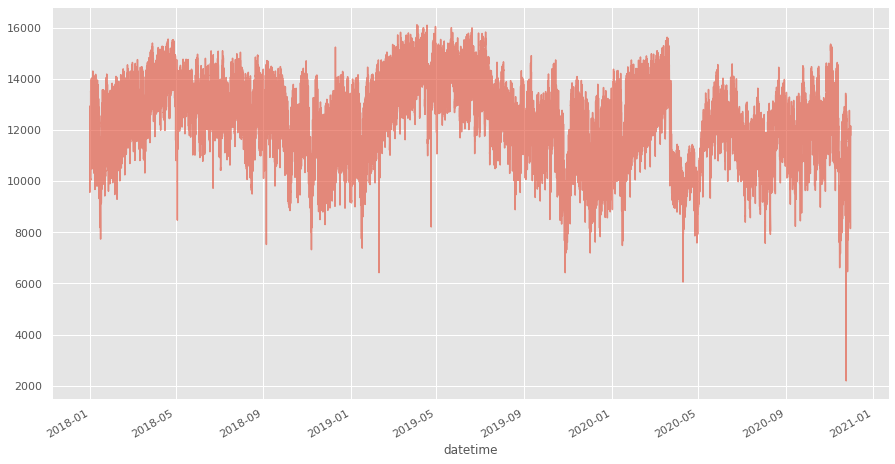

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax = df.VALUE.plot(alpha=0.6)

# 3. Prophet

## 3.1 Prepare data for fbprophet

In [9]:
df = df.reset_index()
df_pp = df[['datetime', 'VALUE']].rename(columns={'datetime': 'ds', 'VALUE': 'y'})

print(df_pp.shape[0], 'rows', 'AND', df_pp.shape[1], 'columns')
print('Min Date:', df_pp.ds.min(), 'AND', 'Max Date:', df_pp.ds.max())
df_pp.head()

101954 rows AND 2 columns
Min Date: 2018-01-01 00:00:00 AND Max Date: 2020-11-30 12:30:00


,ds,y
0,2018-01-01 00:00:00,10058.20
1,2018-01-01 00:15:00,9985.09
2,2018-01-01 00:30:00,9988.30
3,2018-01-01 00:45:00,9983.33
4,2018-01-01 01:00:00,9933.11


### 3.1.1 Resampling

In [10]:
df_hh, df_h, df_d = utils.df_resampling(df_pp)

### 3.1.2 Train and test sets split

In [11]:
# split dataset into train (2018-2020-08-31) and test (2020-09-01)

# df_pp 15 mins interval
df_train_15, df_test_15 = utils.df_train_test_split(df_pp, divider)

# df_hh 30 mins interval
df_train_30, df_test_30 = utils.df_train_test_split(df_hh, divider)

# df_h 60 mins interval
df_train_60, df_test_60 = utils.df_train_test_split(df_h, divider)

# df_d  24 hrs interval
df_train_24, df_test_24 = utils.df_train_test_split(df_d, divider)

In [12]:
df_train_24.tail()

,ds,y
969,2020-08-27,12498.129167
970,2020-08-28,12510.908333
971,2020-08-29,12618.637500
972,2020-08-30,11693.978125
973,2020-08-31,11996.608333


## 3.2 Models

### 3.2.1 Model 1: fbprophet baseline model

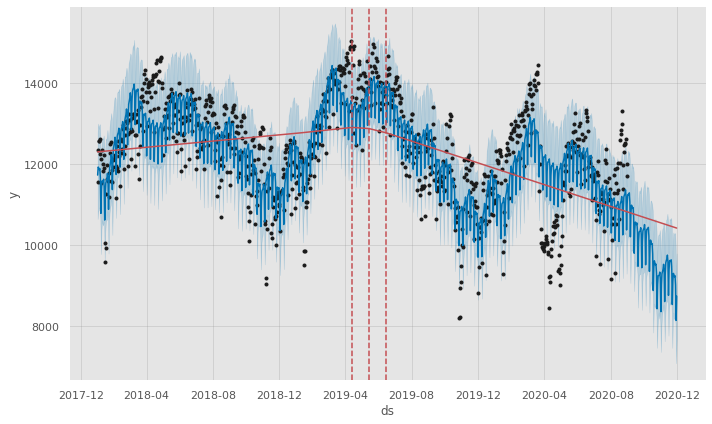

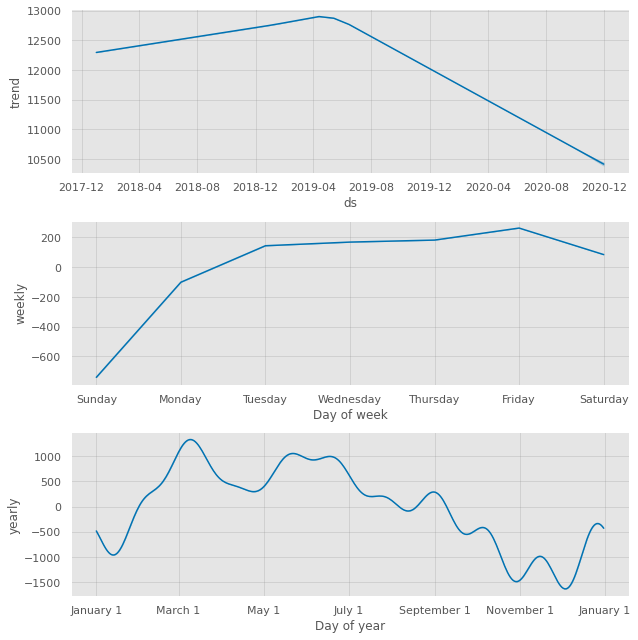

In [13]:
m1, forecast1, cv_results1 = models.baseline(df_train_24, freq='D', periods=len(df_test_24), cv_flag=1)

Model1 - fbprophet cross validation mean absolute percentage error (MAPE): 14.488622975009058
Model 1 MAPE for M-3 forecasting: 6.136281167954184


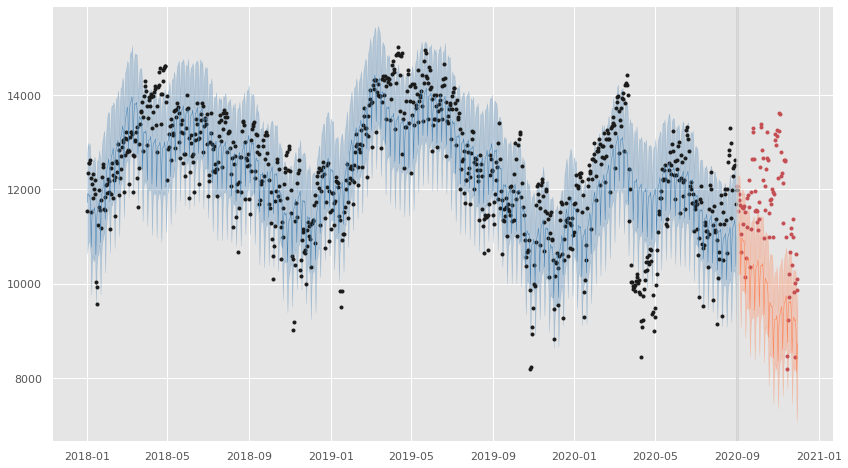

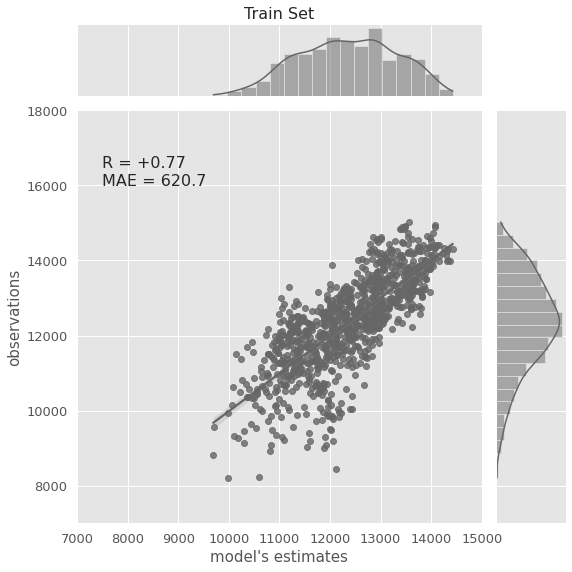

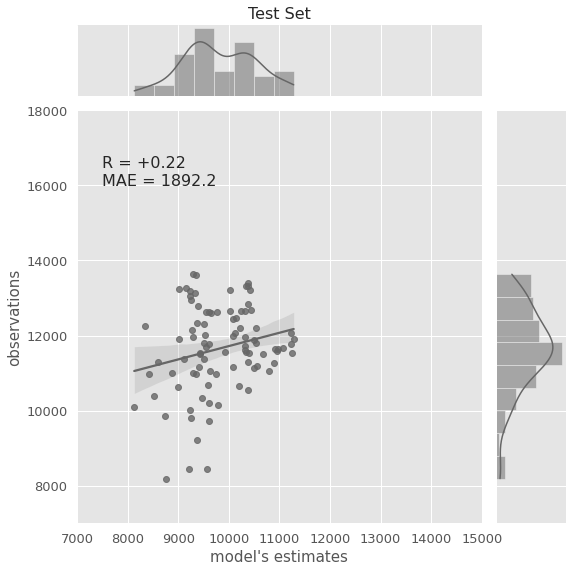

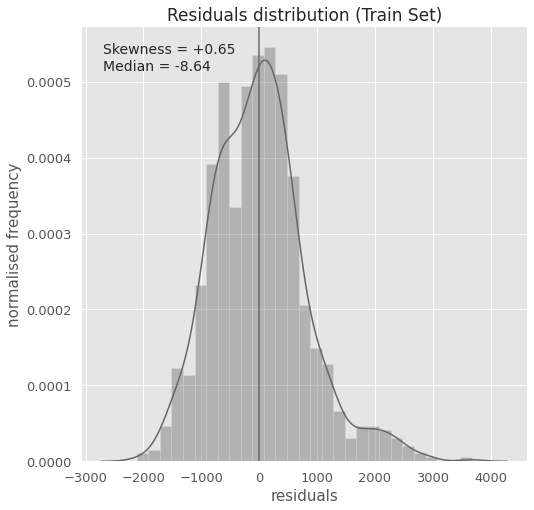

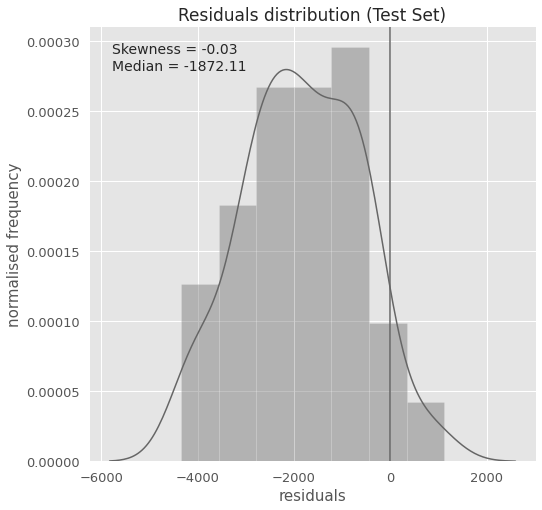

In [14]:
# validation

# model MAPE

mape1 = utils.cv_mape(cv_results1.y, cv_results1.yhat)
print('Model1 - fbprophet cross validation mean absolute percentage error (MAPE): {}'.format(mape1))

verification1 = utils.df_verification(forecast1, df_train_24, df_test_24)
verif_fig1 = utils.plot_verification(verification1, divider)

# forecasting MAPE

mape1_M3 = utils.cv_mape(verification1.y, verification1.yhat)
print('Model 1 MAPE for M-3 forecasting: {}'.format(mape1_M3))

# plot joint plot for train set

fig_joint_train_plot1 = utils.plot_joint_plot(verification1[verification1.index < divider], title='Train Set')

# plot joint plot for test set
fig_joint_test_plot1 = utils.plot_joint_plot(verification1[verification1.index >= divider], title='Test Set')

# plot residual distribution plot for train set
fig_residual_train_plot1 = utils.plot_residuals_dist(verification1[verification1.index < divider], title='Train Set')

# plot residual distribution plot for test set
fig_residual_test_plot1 = utils.plot_residuals_dist(verification1[verification1.index >= divider], title='Test Set')

### 3.2.2 Model 2: fbprophet lockdown and custom holiday model

* add custom holiday as holiday `df`

* add lockdown periods as regressors

/home/yuchang/anaconda3/envs/ts/lib/python3.8/site-packages/fbprophet/hdays.py:259: Warning: We only support Diwali and Holi holidays from 2010 to 2030
  warnings.warn(warning_msg, Warning)


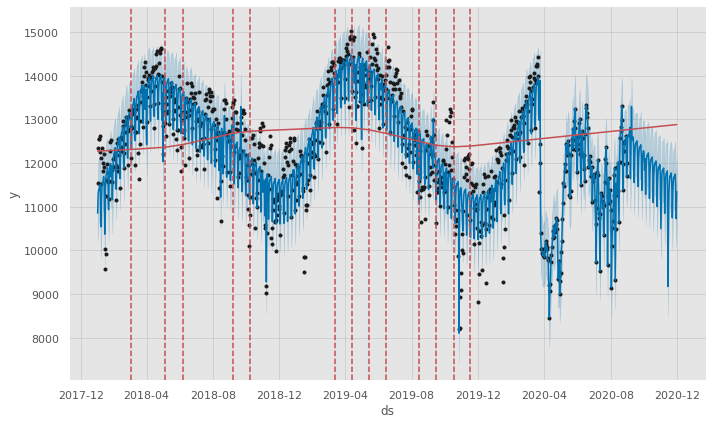

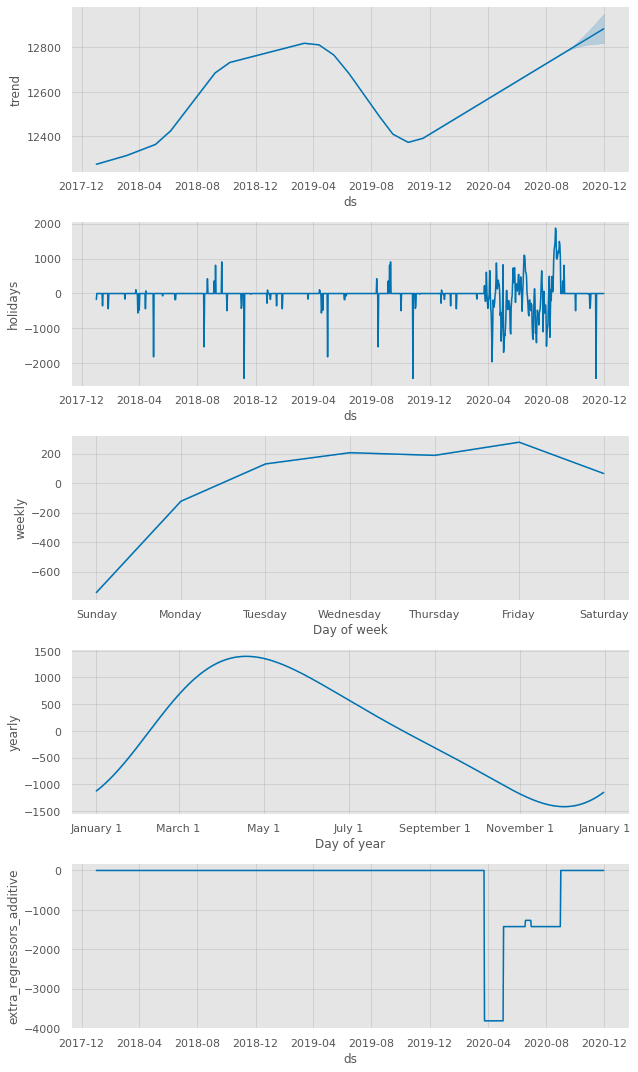

In [15]:
m2, forecast2, cv_results2 = models.with_lockdown_regressors(df_train_24, freq='D', periods=len(df_test_24), cv_flag=1)

Model2 - fbprophet cross validation mean absolute percentage error (MAPE): 13.848759620256414
Model 2 MAPE for M-3 forecasting: 3.4749137644583317


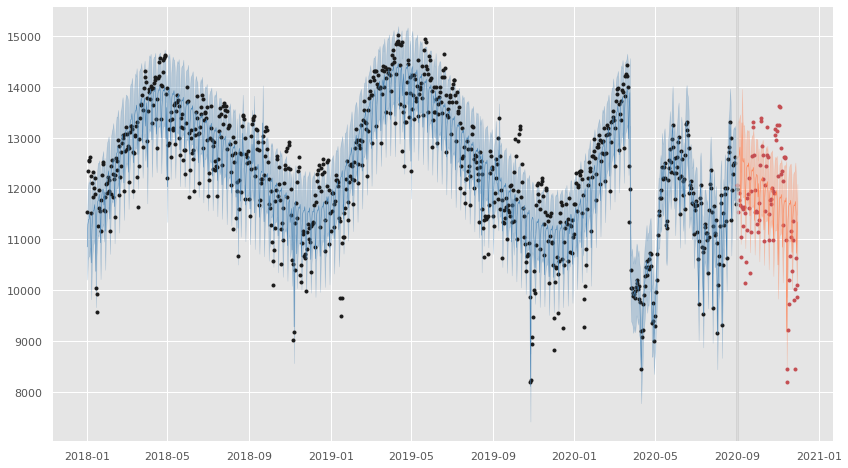

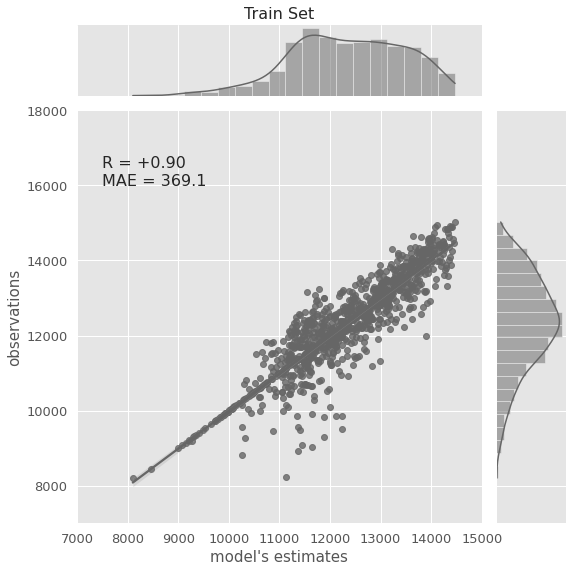

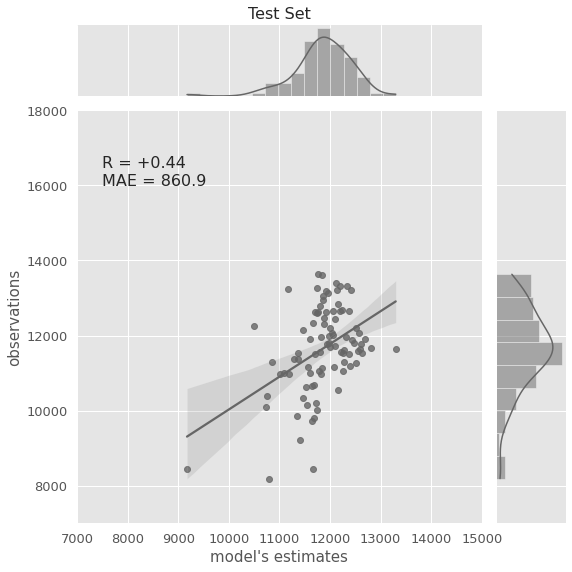

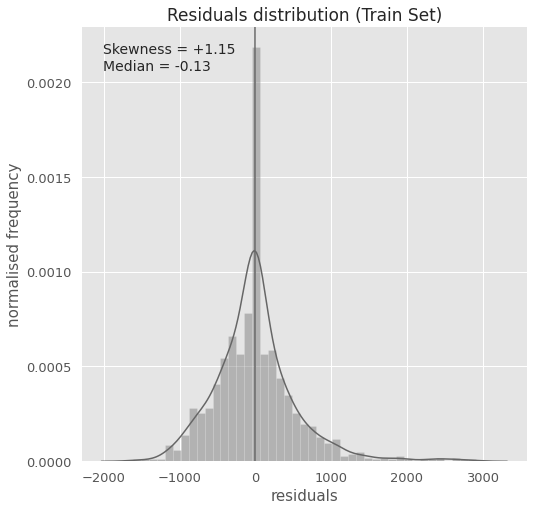

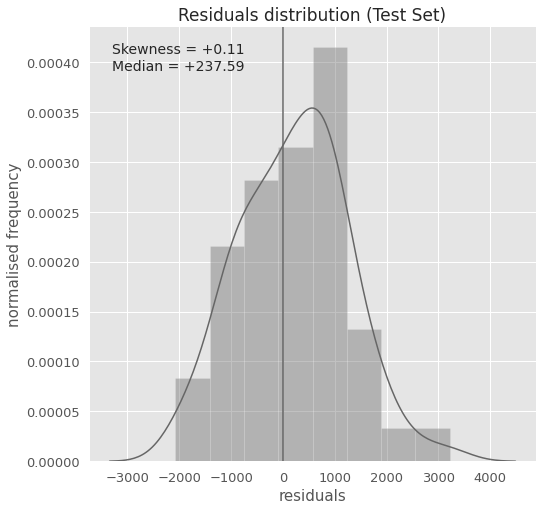

In [16]:
# validation

# model MAPE

mape2 = utils.cv_mape(cv_results2.y, cv_results2.yhat)
print('Model2 - fbprophet cross validation mean absolute percentage error (MAPE): {}'.format(mape2))

verification2 = utils.df_verification(forecast2, df_train_24, df_test_24)
verif_fig2 = utils.plot_verification(verification2, divider)

# forecasting MAPE

mape2_M3 = utils.cv_mape(verification2.y, verification2.yhat)
print('Model 2 MAPE for M-3 forecasting: {}'.format(mape2_M3))

# plot joint plot for train set

fig_joint_train_plot2 = utils.plot_joint_plot(verification2[verification2.index < divider], title='Train Set')

# plot joint plot for test set
fig_joint_test_plot2 = utils.plot_joint_plot(verification2[verification2.index >= divider], title='Test Set')

# plot residual distribution plot for train set
fig_residual_train_plot2 = utils.plot_residuals_dist(verification2[verification2.index < divider], title='Train Set')

# plot residual distribution plot for test set
fig_residual_test_plot2 = utils.plot_residuals_dist(verification2[verification2.index >= divider], title='Test Set')

### 3.2.3 Model 3: fbprophet with weather regressor

* add custom holiday as holiday `df`

* add lockdown periods as regressors

* add extra weather (daily temperature) as regressor

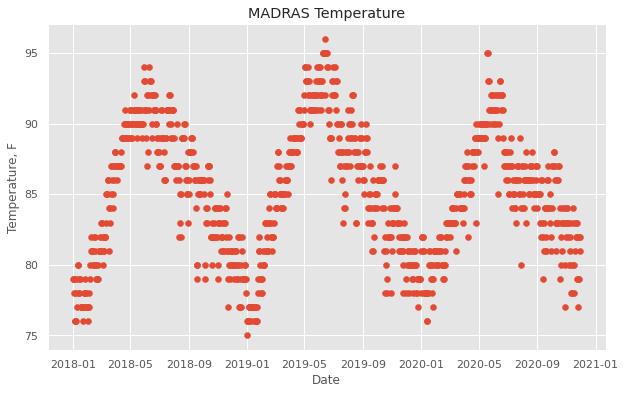

In [17]:
# read weather data

temp = pd.read_csv('data/noaa-2426560.csv')
temp['ds'] = pd.to_datetime(temp.DATE)
temp['temp'] = temp['TAVG']
# interpolate so that there are no missing values
temp = temp.interpolate(method='linear')
temp = temp.loc[:, ['ds', 'temp']]

# scatter plot of temperature

plt.figure(figsize=(10, 6))
plt.scatter(x=temp['ds'], y=temp['temp'])
plt.title('MADRAS Temperature')
plt.xlabel('Date')
plt.ylabel('Temperature, F')
plt.show()

/home/yuchang/anaconda3/envs/ts/lib/python3.8/site-packages/fbprophet/hdays.py:259: Warning: We only support Diwali and Holi holidays from 2010 to 2030
  warnings.warn(warning_msg, Warning)


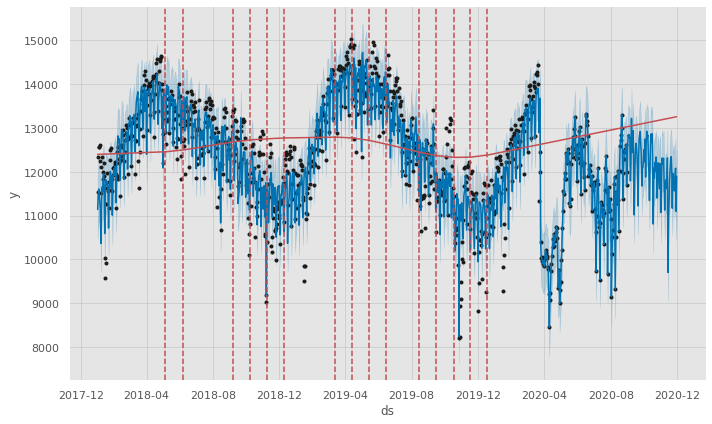

/home/yuchang/anaconda3/envs/ts/lib/python3.8/site-packages/fbprophet/plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
/home/yuchang/anaconda3/envs/ts/lib/python3.8/site-packages/fbprophet/plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
/home/yuchang/anaconda3/envs/ts/lib/python3.8/site-packages/fbprophet/plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)


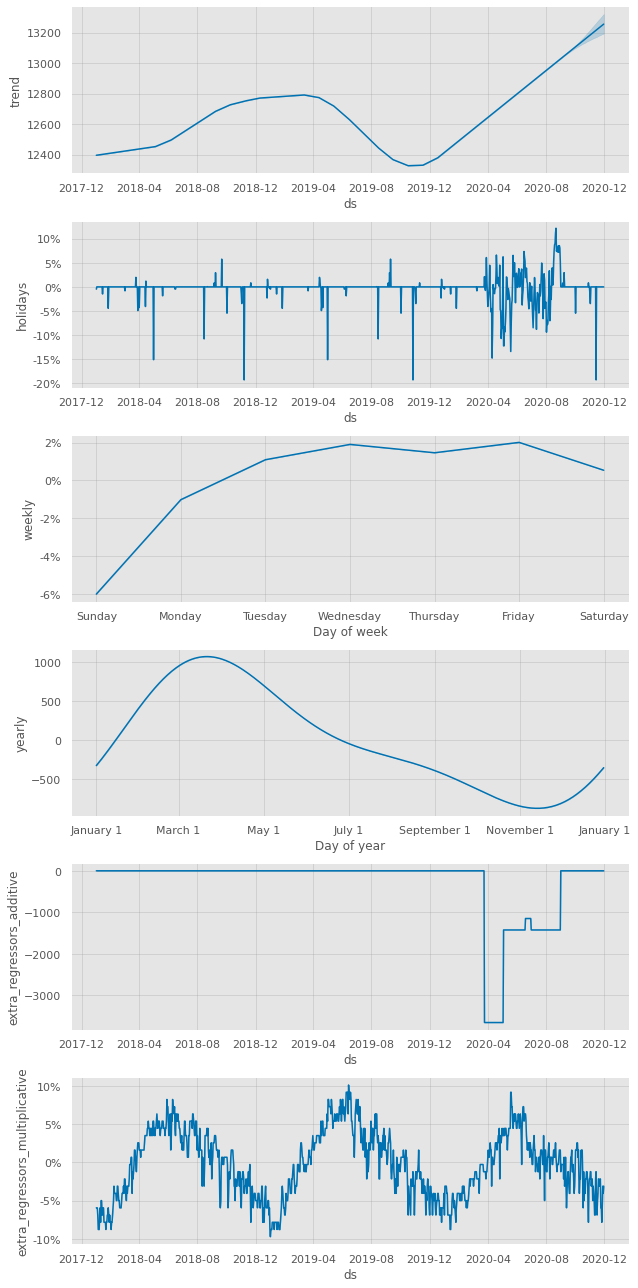

In [18]:
m3, forecast3, cv_results3 = models.with_weather_lockdown_regressors(df_train_24, temp, divider, freq='D', periods=len(df_test_24), cv_flag=1)

Model3 - fbprophet cross validation mean absolute percentage error (MAPE): 11.118960411220396
Model 3 MAPE for M-3 forecasting: 3.3020929423505665


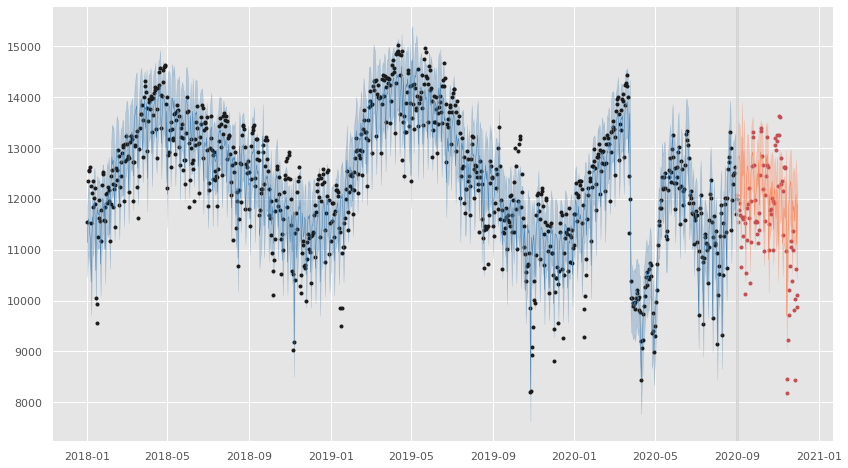

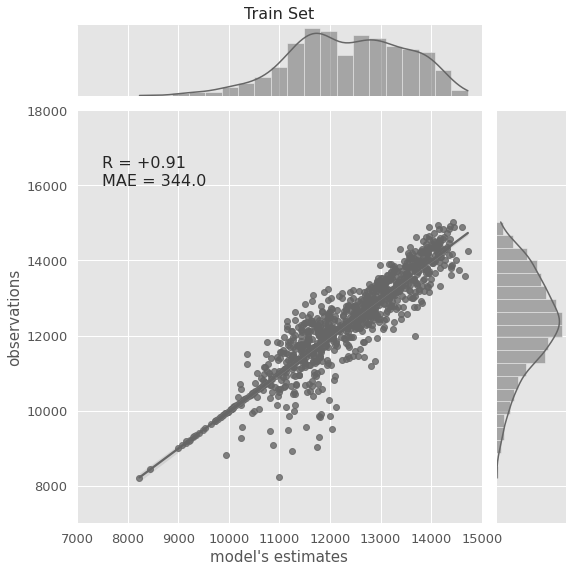

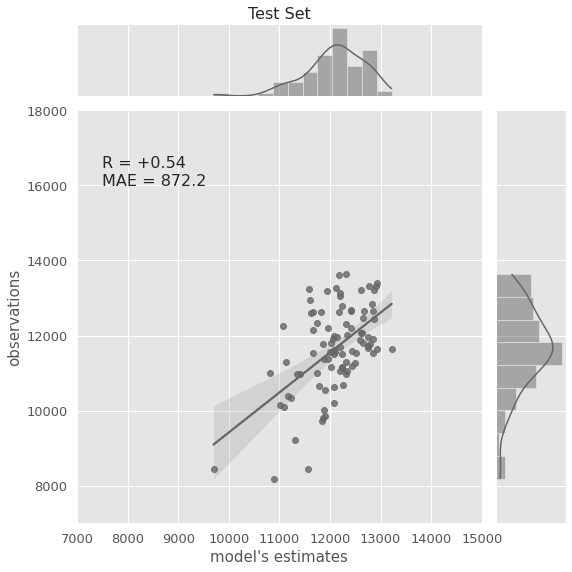

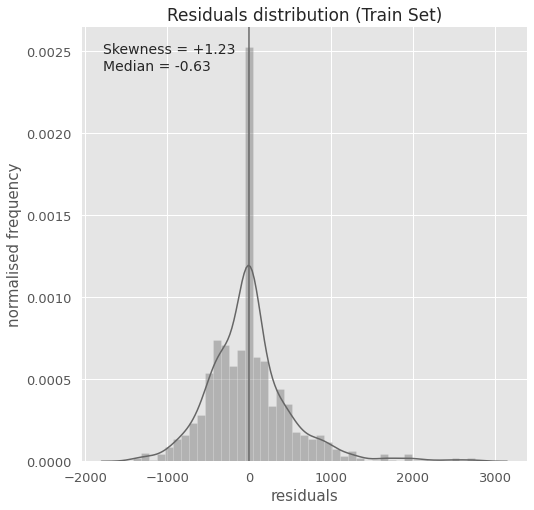

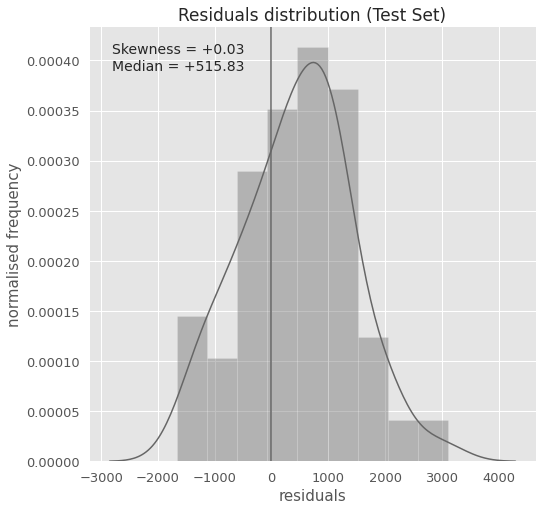

In [19]:
# validation

mape3 = utils.cv_mape(cv_results3.y, cv_results3.yhat)
print('Model3 - fbprophet cross validation mean absolute percentage error (MAPE): {}'.format(mape3))

verification3 = utils.df_verification(forecast3, df_train_24, df_test_24)
verif_fig3 = utils.plot_verification(verification3, divider)

# forecasting MAPE

mape3_M3 = utils.cv_mape(verification3.y, verification3.yhat)
print('Model 3 MAPE for M-3 forecasting: {}'.format(mape3_M3))

# plot joint plot for train set

fig_joint_train_plot3 = utils.plot_joint_plot(verification3[verification3.index < divider], title='Train Set')

# plot joint plot for test set
fig_joint_test_plot3 = utils.plot_joint_plot(verification3[verification3.index >= divider], title='Test Set')

# plot residual distribution plot for train set
fig_residual_train_plot3 = utils.plot_residuals_dist(verification3[verification3.index < divider], title='Train Set')

# plot residual distribution plot for test set
fig_residual_test_plot3 = utils.plot_residuals_dist(verification3[verification3.index >= divider], title='Test Set')